In [24]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
from PIL import Image
import pandas as pd

In [4]:
data_dir = './data'
# def reorg_dog_data(data_dir, valid_ratio):
#     labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
#     d2l.reorg_train_valid(data_dir, labels, valid_ratio)
#     d2l.reorg_test(data_dir)
# valid_ratio  =0.2
# reorg_dog_data(data_dir,valid_ratio)

In [5]:
for test_file in os.listdir(os.path.join(data_dir,'test')):
  print(test_file)
  break

000621fb3cbb32d8935728e48679680e.jpg


array([<AxesSubplot:title={'center':'boston_bull'}>,
       <AxesSubplot:title={'center':'dingo'}>,
       <AxesSubplot:title={'center':'pekinese'}>,
       <AxesSubplot:title={'center':'bluetick'}>,
       <AxesSubplot:title={'center':'golden_retriever'}>], dtype=object)

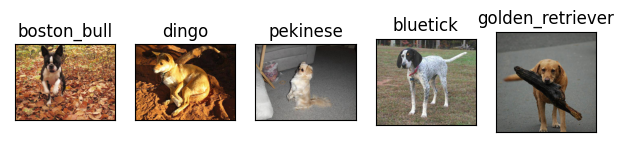

In [6]:
imgs = []
titles = []
labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
for image in os.listdir(os.path.join(data_dir,'train')):
  imgs.append(Image.open(os.path.join(data_dir,'train',image)))
  titles.append(labels[image.split('.')[0]])
  if(len(imgs)>=5):
    break

d2l.show_images(imgs,1,5,titles)

In [7]:
batch_size = 256
transform_train = torchvision.transforms.Compose([
  torchvision.transforms.RandomResizedCrop(224,(0.08,1),(3.0/4.0,4.0/3.0)),
  torchvision.transforms.RandomHorizontalFlip(0.4),
  torchvision.transforms.ColorJitter(0.2,0.2,0.2),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]
)
transform_test = torchvision.transforms.Compose([
  torchvision.transforms.Resize(256),
  torchvision.transforms.CenterCrop(224),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


array([<AxesSubplot:title={'center':'boston_bull'}>,
       <AxesSubplot:title={'center':'dingo'}>,
       <AxesSubplot:title={'center':'pekinese'}>,
       <AxesSubplot:title={'center':'bluetick'}>,
       <AxesSubplot:title={'center':'golden_retriever'}>], dtype=object)

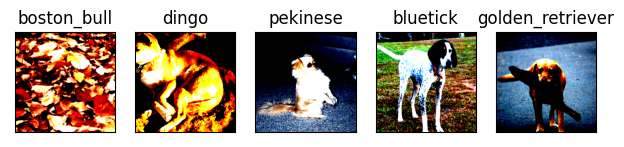

In [8]:
imgs_train = list(map(transform_train, imgs))
for i in imgs:
    print(transform_train(i).shape)
    break

# Convert tensors to numpy arrays and transpose to (H, W, C)
imgs_train_np = [img.permute(1, 2, 0) for img in imgs_train]
d2l.show_images(imgs_train_np, 1, 5, titles)

In [9]:
data_dir = os.path.join('./data','train_valid_test')
train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir,'train'),
                                                 transform=transform_train,
                                                 )
train_valid_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir,'train_valid'),
                                                 transform=transform_train,
                                                 )
valid_dataset, test_dataset = [torchvision.datasets.ImageFolder(
  os.path.join(data_dir,folder),
  transform=transform_test) for folder in ['valid','test']
]

In [10]:
print(f'train data size:{len(train_dataset.samples)}\n',
      f'valid data size:{len(valid_dataset.samples)}\n',
      f'train_valid data size:{len(train_valid_dataset.samples)}\n',
      f'test data size:{len(test_dataset.samples)}\n')

train data size:8662
 valid data size:1560
 train_valid data size:10222
 test data size:10357



In [11]:
train_iter,train_valid_iter = [torch.utils.data.DataLoader(
                                    ds,batch_size,shuffle=True,drop_last=True)
                                    for ds in [train_dataset,train_valid_dataset]
]
valid_iter, test_iter = [torch.utils.data.DataLoader(
                                    ds,batch_size,shuffle=False,drop_last=False)
                                    for ds in [valid_dataset, test_dataset]
]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


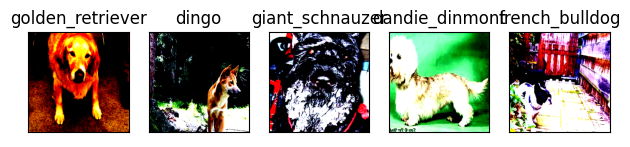

In [13]:
for images, labels in train_iter:
    images = images[0:5]
    labels = labels[0:5]
    labels = [valid_dataset.classes[i] for i in labels]
    imgs_train_np = [img.permute(1, 2, 0) for img in images]
    d2l.show_images(imgs_train_np, 1, 5, labels)
    break

In [14]:
def get_net(device):
    # Load pre-trained ResNet34
    resnet34 = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT)
    # Freeze all layers
    for param in resnet34.parameters():
        param.requires_grad = False
    # Replace the final fully connected layer
    resnet34.fc = nn.Sequential(
        nn.Linear(resnet34.fc.in_features, 256),
        nn.ReLU(),
        nn.Linear(256, 120)
    )
    net = resnet34.to(device)
    return net


In [15]:
loss = nn.CrossEntropyLoss(reduction='none')



In [19]:
from tqdm.notebook import tqdm
def evaluate_loss_acc(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices), labels.to(devices)
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return (l_sum / n).to('cpu')
def train(net,train_iter,valid_iter, num_epochs, lr, wd, device, lr_period, lr_decay):
  trainer = torch.optim.SGD((p for p in net.parameters() if p.requires_grad)
                            ,lr,momentum=0.9,weight_decay=wd)
  lr_scheduler = torch.optim.lr_scheduler.StepLR(trainer,lr_period,lr_decay)
  num_batches = len(train_iter)
  print(f'training on {device}')
  for epoch in range(num_epochs):
    e_total_loss,e_total_samples = 0,0
    for features, y in tqdm(train_iter,
                            total=len(train_iter),
                            desc=f"Epoch {epoch+1}/{num_epochs},lr = {lr_scheduler.get_lr()}",
                            unit='batch',
                            leave=False):
      features,y = features.to(device),y.to(device)
      trainer.zero_grad()
      y_hat = net(features)
      l = loss(y_hat,y).sum()
      l.backward()
      trainer.step()
      e_total_loss+=l
      e_total_samples+= y.shape[0]
    if valid_iter is not None:
      valid_loss = evaluate_loss_acc(valid_iter,net,device)
    lr_scheduler.step()
    mertic = f'Epoch:{epoch+1},train loss:{e_total_loss/e_total_samples},'
    if valid_iter is not None:
      mertic+= f'valid loss:{valid_loss}'
    print(mertic)


In [17]:
devices, num_epochs, lr, wd = d2l.try_gpu(), 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

training on cuda:0


d:\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:536: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 1/10,lr = [0.0001]:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch:1,train loss:4.4000139236450195,valid loss:3.5717430114746094


Epoch 2/10,lr = [0.0001]:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch:2,train loss:2.537916660308838,valid loss:1.6240653991699219


Epoch 3/10,lr = [8.1e-05]:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch:3,train loss:1.4908881187438965,valid loss:1.2203787565231323


Epoch 4/10,lr = [9e-05]:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch:4,train loss:1.240559458732605,valid loss:1.0634130239486694


Epoch 5/10,lr = [7.290000000000001e-05]:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch:5,train loss:1.1715598106384277,valid loss:1.0085527896881104


Epoch 6/10,lr = [8.1e-05]:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch:6,train loss:1.0841535329818726,valid loss:0.9994564056396484


Epoch 7/10,lr = [6.561000000000002e-05]:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch:7,train loss:1.0621609687805176,valid loss:0.950118899345398


Epoch 8/10,lr = [7.290000000000001e-05]:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch:8,train loss:1.0267852544784546,valid loss:0.9342344999313354


Epoch 9/10,lr = [5.904900000000002e-05]:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch:9,train loss:0.9985023736953735,valid loss:0.9304144978523254


Epoch 10/10,lr = [6.561000000000002e-05]:   0%|          | 0/33 [00:00<?, ?batch/s]

Epoch:10,train loss:0.9605579972267151,valid loss:0.8956543803215027


In [20]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

training on cuda:0


d:\anaconda3\envs\d2l\lib\site-packages\torch\optim\lr_scheduler.py:536: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 1/10,lr = [0.0001]:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch:1,train loss:4.273233413696289,


Epoch 2/10,lr = [0.0001]:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch:2,train loss:2.169191837310791,


Epoch 3/10,lr = [8.1e-05]:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch:3,train loss:1.388845443725586,


Epoch 4/10,lr = [9e-05]:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch:4,train loss:1.2170019149780273,


Epoch 5/10,lr = [7.290000000000001e-05]:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch:5,train loss:1.106532096862793,


Epoch 6/10,lr = [8.1e-05]:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch:6,train loss:1.0615180730819702,


Epoch 7/10,lr = [6.561000000000002e-05]:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch:7,train loss:1.0254117250442505,


Epoch 8/10,lr = [7.290000000000001e-05]:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch:8,train loss:1.006502628326416,


Epoch 9/10,lr = [5.904900000000002e-05]:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch:9,train loss:0.9729147553443909,


Epoch 10/10,lr = [6.561000000000002e-05]:   0%|          | 0/39 [00:00<?, ?batch/s]

Epoch:10,train loss:0.9626202583312988,


In [21]:
device = d2l.try_gpu()
preds = []
for x,y in test_iter:
  pred = nn.functional.softmax(net(x.to(device)),dim =1)
  preds.extend(pred.cpu().detach().numpy())


In [33]:
ids = [os.path.basename(file) for file,_ in test_dataset.samples]
submisson = pd.DataFrame({'id':ids})
len(preds[0])
with open('submission.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_dataset.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join(
            [str(num) for num in output]) + '\n')